In [1]:
%matplotlib notebook
import matplotlib.animation as ani
import matplotlib.colors as colors
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from planetThermo import pco2
from planetThermo import tco2
import scipy.linalg
from scipy.interpolate import pchip
import statsmodels.api as sm
import pickle
plt.rc('font', family='serif')
plt.rcParams['font.weight']= 'heavy'
plt.rcParams.update({'font.size': 12})

In [2]:
#I've saved the binning routines to a module python file

#List of binning methods:

#Zonal mean binning with Altitude z-axis: 
from Snowfall_growth_modules import Alt_Lat_binning

#Finding number densities given opacities   
from Snowfall_growth_modules import find_Nd_vels

##import the radius profile functions:
from Snowfall_growth_modules import IR_cooling_radii_vels

#import the functions to interpolate to smaller altitude steps
from Snowfall_growth_modules import Z_interpolater

#import Median finder function
from Snowfall_growth_modules import Median_Ls

##import cloud settling model
from Snowfall_growth_modules import Cloud_Growth_CN
#
##import the water build up functions
from Snowfall_growth_modules import All_lat_snowfall
from Snowfall_growth_modules import N_Water_buildup as Water_buildup
from Snowfall_growth_modules import N_CO2_buildup as CO2_buildup

##import data manipulation functions
from Snowfall_growth_modules import Ls_filler

from Snowfall_growth_modules import remove_outliers

In [3]:
#reading from parquet file
#df = pd.read_parquet('MCS_MY29_20081225_20091026.parquet.gzip'); yr = 29 ; removeables = ['215.0','219.0','270.0'] ; missing_Ls = [215 ,270,279, 317, 328] ; dups = [5,1,2,2,32]
#df = pd.read_parquet('MCS_MY30_20101112_20110913.parquet.gzip'); yr = 30 ; removeables = ['189.0','311.0'] ; missing_Ls = [189, 311] ; dups = [1,1]
df = pd.read_parquet('MCS_MY31_20120731_20130731.parquet.gzip'); yr = 31 ; removeables = ['262.0','293.0'] ; missing_Ls = [189, 262, 293] ; dups = [1,1,1]
#df = pd.read_parquet('MCS_MY32_20130713_20150618.parquet.gzip'); yr = 32 ; removeables = ['190.0','194.0','248.0'] ; missing_Ls = [186, 190, 194, 248, 319] ; dups = [1,1,1,1,1]
#df = pd.read_parquet('MCS_MY33_20150618_20170505.parquet.gzip'); yr = 33 ; removeables = [] ; missing_Ls = [180,245] ; dups = [1,2]
#df = pd.read_parquet('MCS_MY34_20171028_20190322.parquet.gzip'); yr = 34 ; removeables = ['190.0','221.0','222.0','262.0'] ; missing_Ls = [190,220, 262,270, 296] ; dups = [1,4,1,10,1]
#df = pd.read_parquet('UPDATED_MCS_MY35_20200408_20210207.parquet.gzip'); yr = 35  ; removeables = ['183.0','187.0','213.0'] ;  missing_Ls = [183,213, 219, 296] ; dups = [5,1,4,3]

In [4]:
# create a new dataframe that only includes the polar vortex of the north pole region (North Polar Vortex)
NPV = df[(df.LS <= 360)&(df.LS >=180)&(df.ALTITUDE <= 40)&(df.LATITUDE >= 65)&(df.LATITUDE <= 87)]
#resetting index of new dataframe
NPV = NPV.reset_index()
NPV = NPV.drop(['index'],axis = 1)

#calculate the frost point for each entry
NPV['T_frost'] = tco2(0.95*NPV.PRESSURE)

# create a new dataframe that only includes the CO2 measurements,, which is anywhere where the recorded 
#temp is equal to or less than the frost point
NPVC = NPV[(NPV.TEMPERATURE <= NPV.T_frost+5)]
#resetting index of new dataframe
NPVC = NPVC.reset_index()
NPVC = NPVC.drop(['index'],axis = 1)

#bin the data
LatV,AltV, Vtemp = Alt_Lat_binning(NPVC,'temp',1)
LatV,AltV, dust = Alt_Lat_binning(NPVC,'dust',1) #here, dust is actually co2 since we've seperated out the co2 from the dust data
LatV,AltV, Vh2oice = Alt_Lat_binning(NPVC,'h2oice',1)
latV,AltV, Vpress = Alt_Lat_binning(NPVC,'pressure',1)
names = list(Vtemp.keys())
#convert Ls names list into integers
intnames = np.array(names).astype(np.float).astype(np.int)

In [5]:
## 1 extracting the full WATER no. density profile 

#for indexing purposes
names = list(Vtemp.keys())

#define constants/inputs (using km as base length)
Qh = 0.7467 #efficiency of extinction for water ice
ah = 4e-6 #m molecule cross section 
rhoh = 1000 #individual particle mass density of water ice (Cotton et al 2013 JRMS)

R_m = 3.3895e6 #radius of Mars in m

h = 1000 #m # vertical height of 1 pixel

mu = 8.5e-6 #(kg/ m s) OR (Pa s) # molecular viscosity of atmosphere at 150 K

G = 6.67408e-11 #m3/kg s  # gravitational constant

Kb = 1.38064852e-23 #m2 kg/ s2 K #boltzmann constant

M_m = 6.39e23 #kg # mass of Mars in Kgrams

gr = 3.711 #m/s²

Tav = 140 #K #average temp at the poles

#create empty dictionaries to store results
N_H2Odensity = dict()


#Scale the altitude to be in meters:
SAltV = AltV*1e3
#quick note on how the dictionary data can be accessed for example the dust matrix:
#h2oice[names[frame(ls) index]][altitude index][latitude index]
#this is important to mention since I will need to access the info saved in 
#the binning dictionary to perform this analysis

#loop through each entry in the co2ice dict
for i in tqdm(range(len(Vh2oice))):
    # redefine the array of co2ice value
    T = Vtemp[names[i]] #K
    P = Vpress[names[i]]#kg/m s2 OR Pa
    H = Vh2oice[names[i]]*1e-3 #m^-1 (multiply by 1e-3 to convert from km-1 to m-1)
    
    #step 1: convert the H2O ice opacities to optical depth
    H = H*h
    #step 2: calculate the no. density of H2O ice particles in each pixel
    
    N_h = H/(Qh*np.pi*(ah**2)*h) 
    
    #step 2.5 calculate the scale height of the atmosphere:
    polartemp = np.nanmean(np.ma.masked_where(T == 0, T))
    Scale_H = (Kb*polartemp)/(44*1.67e-27*gr)
    
    #step 3
    #finding the index of the bottom most non nan entry
    for j in range(len(LatV)-1):
        #first find the indices of all non nan entries in that column
        nonnan = np.argwhere(~np.isnan(N_h[:,j])&~(N_h[:,j]==0))
        
        #don't do anything for columns with all nan entries
        if nonnan.size == 0:
            pass
        #for columns with non nan entries, extrapolate to the bottom using the bottom most non nan entry
        else:
            for m in range(len(nonnan)-1):
                if nonnan[m+1] - nonnan[m] >= 5:
                    delidx = int(nonnan[m+1])
                    N_h[delidx:,j] = 0
                    P[delidx:,j] = np.nan
                else:
                    continue
            
            bottomindex = np.int(np.min(nonnan))
            #take the av of the two bottom most entries for the extrapolation
            if N_h[bottomindex+1][j] > 0: 
                AvN_h = (N_h[bottomindex][j] + N_h[bottomindex+1][j])/2
                AvP = (P[bottomindex][j] + P[bottomindex+1][j])/2
                #set the bottom most entry to be the av
                N_h[bottomindex][j] = AvN_h 
                P[bottomindex][j] = AvP
            else:
                AvN_h = N_h[bottomindex][j]
                AvP = P[bottomindex][j]
                
            #using n = n_o exp(-z/H) find the no. density at each altitude below the bottom most entry
            for z in range(bottomindex):
                #using n = n_o exp(-z/H) find the no. density at each altitude below the bottom most entry
                
                N_sh = (AvN_h/(np.exp(-SAltV[bottomindex]/Scale_H)))*(np.exp(-SAltV[z]/Scale_H))
                Pressures = (AvP/(np.exp(-SAltV[bottomindex]/Scale_H)))*(np.exp(-SAltV[z]/Scale_H))
                
                N_h[z][j] = N_sh
                P[z][j] = Pressures
                   
    
    #remove all nan values
    N_h[np.isnan(N_h)] = 0  
    
    N_H2Odensity[names[i]] = N_h

100%|██████████| 179/179 [00:00<00:00, 368.27it/s]


In [6]:
## calculating opacity for CO2 and Extrapolating the values to the surface

#for indexing purposes
names = list(Vtemp.keys())

#define constants/inputs (using km as base length)

R_m = 3.3895e6 #radius of Mars in m

h = 1000 #m # vertical height of 1 pixel

mu = 8.5e-6 #(kg/ m s) OR (Pa s) # molecular viscosity of atmosphere at 150 K

G = 6.67408e-11 #m3/kg s  # gravitational constant

Kb = 1.38064852e-23 #m2 kg/ s2 K #boltzmann constant

dc = 3.3e-10 #m CO2 molecule diameter

M_m = 6.39e23 #kg # mass of Mars in Kgrams

gr = 3.711 #m/s²

Tav = 140 #K #average temp at the poles

#create empty dictionaries to store results
Opacity = dict() #no density of CO2 particles
Temp = dict() #updated temperature dictionary with gaps filled (will be used in IR flux calculations later)
Press = dict() #updated pressure dictionary with gaps filled (will be used in IR flux calculation later)
Frost = dict() #calculated CO2 frost temperature 

#Scale the altitude to be in meters:
SAltV = AltV*1e3
#quick note on how the dictionary data can be accessed for example the dust matrix:
#h2oice[names[frame(ls) index]][altitude index][latitude index]
#this is important to mention since I will need to access the info saved in 
#the binning dictionary to perform this analysis

#loop through each entry in the co2ice dict
for i in tqdm(range(len(names))):
    # redefine the array of co2ice value
    T = Vtemp[names[i]] #K
    P = Vpress[names[i]]#kg/m s2 OR Pa
    
    Tfrost = tco2(0.95*P) #K frost temp of CO2 
    
    # define the array of dust opacities
    Dust = dust[names[i]]
    
    O_c = 2.3*Dust*1e-3 #m^-1 (multiply by the scaling ratio = 2.3(source: Dave's work for Paul and Carlos's paper))
                        #(multiply by 1e-3 to convert from km-1 to m-1) 
    
    #step 2.5 calculate the scale height of the atmosphere:
    polartemp = np.nanmean(np.ma.masked_where(T == 0, T))
    Scale_H = (Kb*polartemp)/(44*1.67e-27*gr)
    #step3: calculate mass flux due to gravitational settling 
    
    #empty array to store the settling velocity w
    w = np.zeros(shape =(P.shape[0],P.shape[1]))
    
    #finding the index of the bottom most non nan entry
    for j in range(len(LatV)-1):
        #first find the indices of all non nan entries in that column
        nonnan = np.argwhere(~np.isnan(P[:,j])&~(P[:,j]==0))
        #don't do anything for columns with all nan entries
        if nonnan.size == 0:
            pass
        #for columns with non nan entries, extrapolate to the bottom using the bottom most non nan entry
        else:
            # first remove outliers from the top of atmosphere (if 5 or more bins away from column)
            for m in range(len(nonnan)-1):
                if nonnan[m+1] - nonnan[m] >= 5:
                    delidx = int(nonnan[m+1])
                    P[delidx:,j] = np.nan
                else:
                    continue
            
            bottomindex = np.int(np.min(nonnan))
            
            #take the av of the bottom two points for the extrapolation
            if P[bottomindex+1][j] > 0: 
                AvP = (P[bottomindex][j] + P[bottomindex+1][j])/2
                #set the bottom most entry to be the av
                P[bottomindex][j] = AvP
            else:
                AvP = P[bottomindex][j]
            
            #using P = P_o exp(-z/H) find the pressure at each altitude below the bottom most entry
            for z in range(bottomindex):
                #using P = P_o exp(-z/H) find the no. density at each altitude below the bottom most entry
            
                Pressures = (AvP/(np.exp(-SAltV[bottomindex]/Scale_H)))*(np.exp(-SAltV[z]/Scale_H))
                P[z][j] = Pressures
                
                frost_temp = tco2(0.95*Pressures) #fill in frost temp of CO2 for those lower parts using new calculated pressure 
                
                Tfrost[z][j] = frost_temp
                #also fill in the temperarture for those missing layers, if the temp of the bottom most entry
                #is greater than the frost temp of CO2, use that. Otherwise use the Tfrost of CO2 cause that is our minimum
                if T[bottomindex][j] >= frost_temp:
                    T[z][j] = T[bottomindex][j]
                else:
                    T[z][j] = frost_temp
            
    
    
    #remove all nan values
    O_c[np.isnan(O_c)] = 0  
    T[np.isnan(T)] = 0 
    P[np.isnan(P)] = 0 
    Tfrost[np.isnan(Tfrost)] = 0 
    
    
    Opacity[names[i]] = O_c
    Temp[names[i]] = T
    Frost[names[i]] = Tfrost
    Press[names[i]] = P

100%|██████████| 179/179 [00:04<00:00, 43.26it/s]


<IPython.core.display.Javascript object>


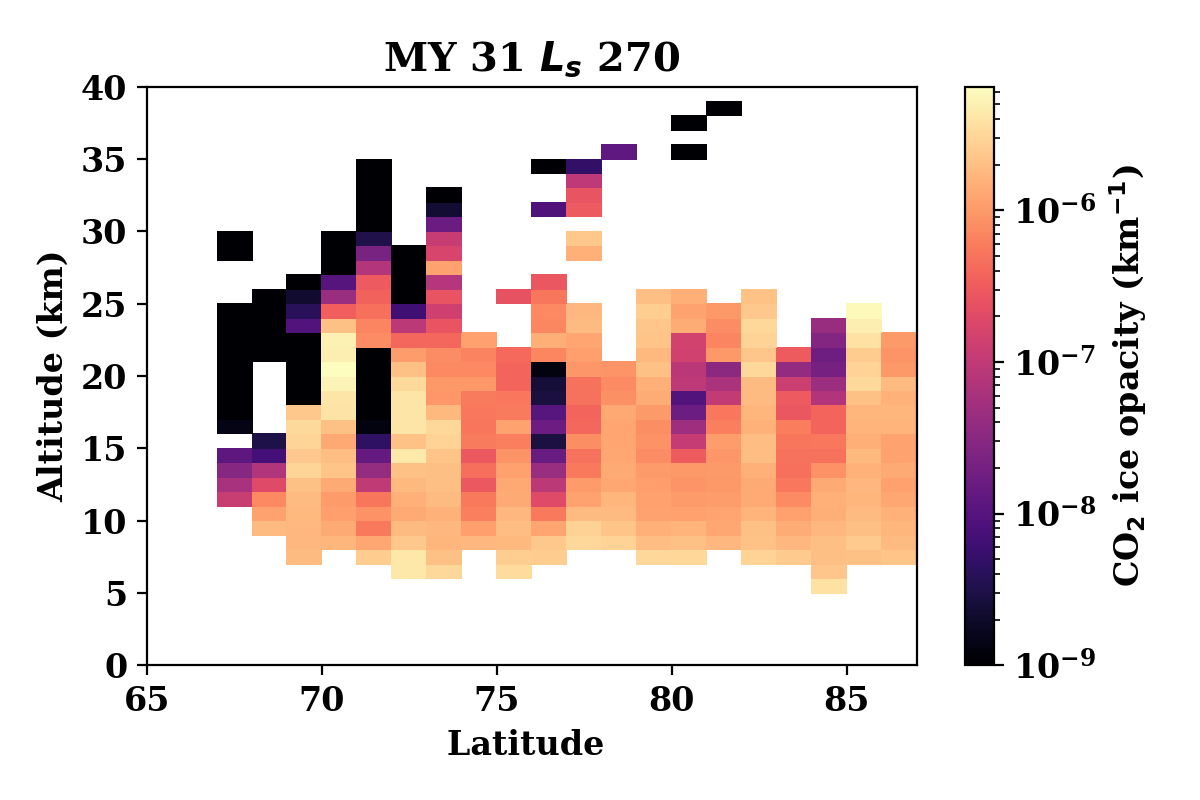

In [9]:
#CREATING OPACITY PLOT
   

import matplotlib.colors as mpltcolors

name = '270.0'


figure = plt.figure(figsize=(6, 4))

plt.pcolormesh(LatV,AltV,Opacity[name], norm=mpltcolors.LogNorm(vmin=1e-9, vmax=np.nanmax(Opacity[name])), cmap ='magma')
cb = plt.colorbar()
cb.set_label(label = 'CO$_2$ ice opacity (km$^{-1}$)',weight='bold')

plt.ylabel('Altitude (km)',fontweight='bold')
plt.xlabel('Latitude ',fontweight='bold')
plt.title('MY '+ np.str(yr) +' $L_s$ '+np.str(np.int(np.float(name))),fontweight='bold')
plt.tight_layout()
plt.savefig('PAPERPLOT_M31_Ls_270_North_CO2_ice_opacity.jpeg', dpi = 300)
plt.show()

<IPython.core.display.Javascript object>


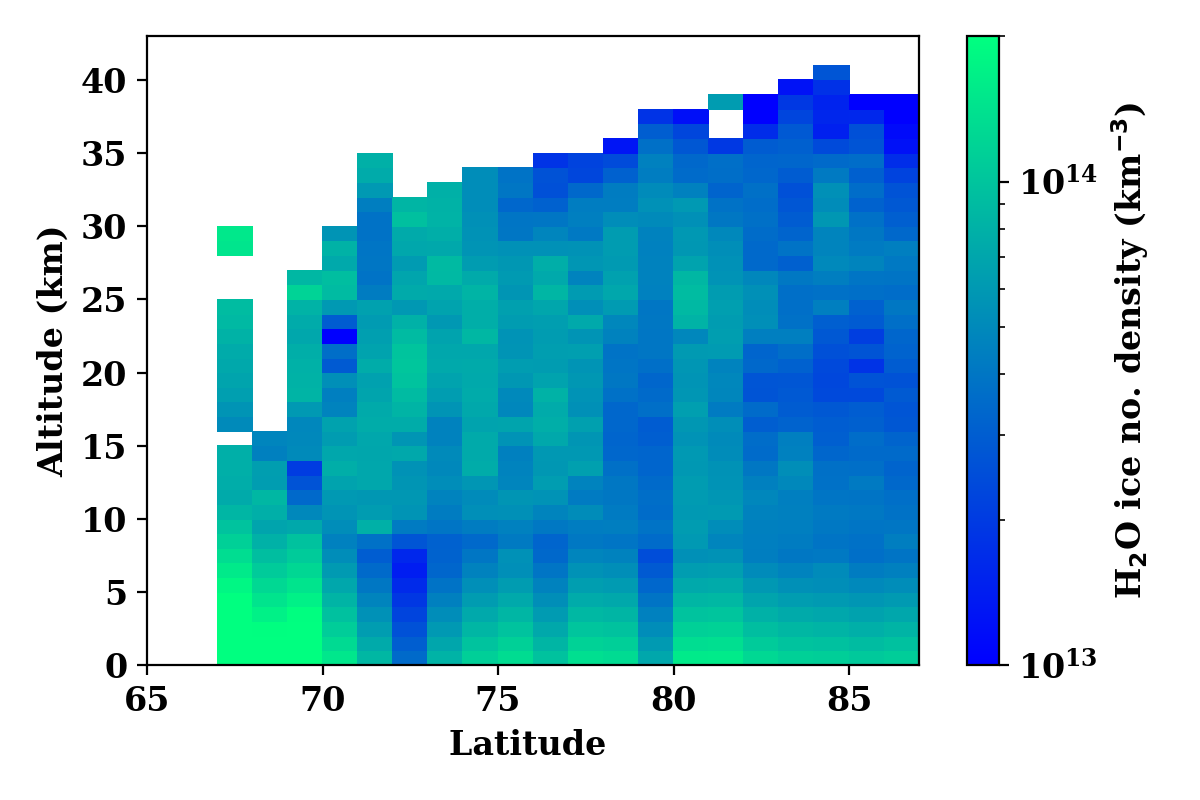

In [11]:
name = '270.0'

figure = plt.figure(figsize=(6, 4))
minval = np.min(N_H2Odensity[name][np.nonzero(N_H2Odensity[name])])
maxval = np.max(N_H2Odensity[name][np.nonzero(N_H2Odensity[name])])

ice = plt.pcolormesh(LatV,AltV,N_H2Odensity[name]*1e9, norm=mpltcolors.LogNorm(vmin=1e13, vmax=2e14),cmap='winter')
#plt.contour(LatV[1:]-0.5,AltV[1:]-0.5,Vtemp[name], [130,135,140,145], colors='k')
cb = plt.colorbar(ice)
cb.set_label(label = 'H$_2$O ice no. density (km$^{-3}$)',weight='bold')

plt.ylabel('Altitude (km)',fontweight='bold')
plt.xlabel('Latitude ',fontweight='bold')
plt.title('MY '+ np.str(yr) +' $L_s$ '+np.str(np.int(np.float(name))),fontweight='bold')
plt.tight_layout()
#plt.savefig('M31_Ls_270_North_H2O_ice_density.jpeg', dpi = 300)
plt.show()

In [7]:
ptcl_size = 3.2e-5
#testing it out for a single column (one Latitude) in one Ls
name = '270.0'
latidx = 17
opc = Opacity[name][:,latidx]
press = Press[name][:,latidx]
tfrost = Frost[name][:,latidx]

altmax = np.where(press == 0)[0][0]

#set the new step size
dz = 1*1000 #m
M_den, M_press, M_frost, M_vels = Median_Ls(Opacity[name],Press[name],ptcl_size,dz)

start_radii = ptcl_size*np.ones(len(M_den))
T = 60*60*3 #sec
dt = 60 #sec
Radius_evol, Vel_evol = IR_cooling_radii_vels(M_den,M_frost,M_press, start_radii, M_vels,dz,dt,T,ptcl_size)


##calculate the smoothened arrays for the specific latitude
opc_smooth, z_array = Z_interpolater(opc,dz,altmax)
press_smooth, alts = Z_interpolater(press,dz,altmax)
tfrost_smooth, alts = Z_interpolater(tfrost,dz,altmax)


K = 1e3 #m2/s

lat_rho,vels,num_den_exp = find_Nd_vels(opc_smooth,press_smooth,ptcl_size,dz)


N_new, zs, tt, N_evolution,flux,surface_r= Cloud_Growth_CN(lat_rho,press_smooth,Radius_evol,Vel_evol,T, dz, dt, K)


<IPython.core.display.Javascript object>


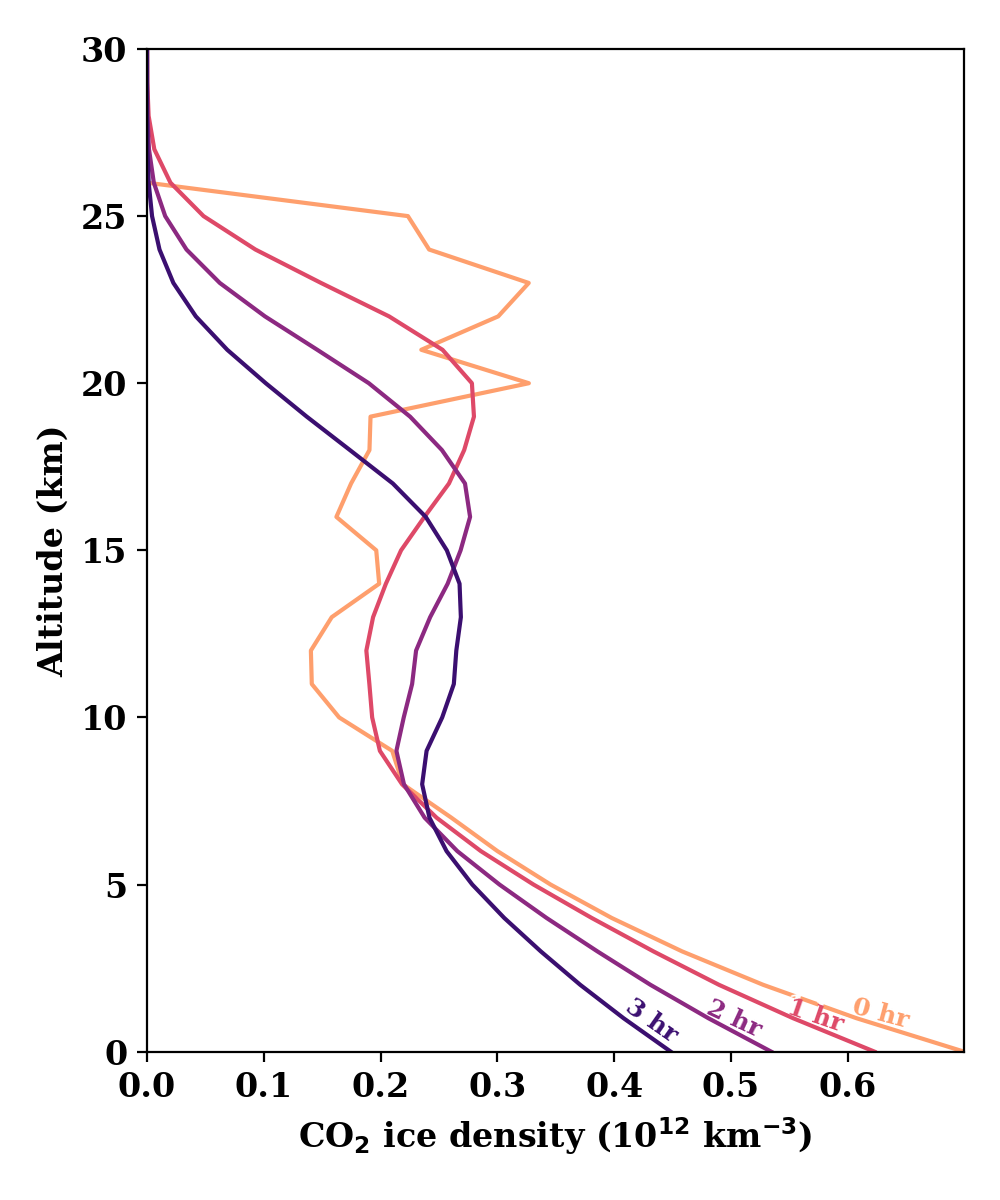

In [8]:
#PLOTTING THE CLOUD SETTLING SEQUENCE

#Create color map
colors = plt.cm.magma(np.linspace(0,1,6))

fig,ax = plt.subplots(figsize=(5,6))

ax.plot(N_evolution[:,0]*1e-3,zs[:-1]*1e-3, color = colors[4] ) #start
ax.plot(N_evolution[:,60]*1e-3,zs[:-1]*1e-3, color = colors[3] ) # 1 hr in
ax.plot(N_evolution[:,120]*1e-3,zs[:-1]*1e-3, color = colors[2] ) # 2 hrs in
ax.plot(N_evolution[:,180]*1e-3,zs[:-1]*1e-3, color = colors[1] ) # 3 hrs in

ax.set_xlabel( 'CO$_2$ ice density (10$^{12}$ km$^{-3}$)', fontweight = 'bold')
ax.set_ylabel('Altitude (km)', fontweight = 'bold')
#ax.set_title('MY '+np.str(yr)+' Ls '+np.str(np.int(np.float(name)))+' '+np.str(np.int(np.float(latV[latidx]))), fontweight = 'bold')
ax.set_ylim(0,30)
ax.set_xlim(0, np.nanmax(N_evolution[:,0]*1e-3))
ax.text(0.86, 0.024, '0 hr',rotation = -15, transform=ax.transAxes, fontsize='9',color=colors[4])
ax.text(0.775, 0.02, '1 hr',rotation = -19, transform=ax.transAxes, fontsize='10',color='white')
ax.text(0.78, 0.02, '1 hr',rotation = -19, transform=ax.transAxes, fontsize='9',color=colors[3])
ax.text(0.68, 0.015, '2 hr',rotation = -25, transform=ax.transAxes, fontsize='9',color=colors[2])
ax.text(0.58, 0.01, '3 hr',rotation = -35, transform=ax.transAxes, fontsize='9',color=colors[1])
plt.tight_layout()
plt.savefig('PAPERPLOT_Single_cloud_evolution_MY31_Ls270_82N.jpeg',dpi=300)

In [ ]:
# Remove any Ls with only partial data or bad data 

for i in removeables:
    names.remove(i)

intnames = np.array(names).astype(np.float).astype(np.int)

In [15]:
# PERFORM ANALYSIS FOR ENTIRE WINTER SEASON
#set particle radius:
ptcl_size = 3.2e-5#m
#Set up the total time to run each settling run
hrlength = 3
T = 60*60*hrlength #sec
#time step 
dt = 60 #sec
#altitude step
dz = 1*1e3 #m
#diffusion coefficient
K = 1e3 #m2/s
# Find the buildup of water for the entire winter season
#assume that the snapshot of one LS is representative cloud profile for that Ls
#assuming the cloud is depleted in approx X hours, multiply the amnt of water by the number of X hour periods in each LS
#its never depleted so just multiply by how many X hour periods there are and run for one whole Ls
Lstohr = np.array([40.853, 38.551, 37.894, 38.962, 41.839, 45.785]) #got this from lmd website martian sols to Ls
LstoNhr = Lstohr/hrlength
#create empty matrix to store water deposited per latitude, evolving through time:
wat_dep = np.zeros(shape = (len(names),LatV.size-1)) #first index is time, second is lat
watmass = np.zeros(shape = (len(names),LatV.size-1)) #first index is time, second is lat
#create empty matrix to store CO2 deposited per latitude, evolving through time:
dry_dep = np.zeros(shape = (len(names),LatV.size-1)) #first index is time, second is lat
drymass = np.zeros(shape = (len(names),LatV.size-1)) #first index is time, second is lat
#create empty matrix to store CO2 particle radius evolving through time:
CO2_radii = np.zeros(shape = (len(names))) #first index is time, second is lat

for i in tqdm(range(len(names))):
    New_density,N_time_evolution,Sed_evol_lat,surface_radius= All_lat_snowfall(Opacity[names[i]],Press[names[i]],Frost[names[i]],T,dz,dt,K,LatV,ptcl_size)
    Sed_evol_lat[np.isnan(Sed_evol_lat)] = 0
    Sed_evol_lat[Sed_evol_lat<=0] = 0
    #Sed_evol_lat[Sed_evol_lat>=1e13] = 0
    H2O_cum, H2O_mass = Water_buildup(Sed_evol_lat,LatV,dt)
    CO2_cum, CO2_mass = CO2_buildup(Sed_evol_lat,surface_radius,LatV,dt)
    LS = np.array(names[i]).astype(np.float).astype(np.int)
    if LS <= 210:
        MULTY = LstoNhr[0]
    elif 210 < LS <= 240:
        MULTY = LstoNhr[1]
    elif 240 < LS <= 270:
        MULTY = LstoNhr[2]
    elif 270 < LS <= 300:
        MULTY = LstoNhr[3]
    elif 300 < LS <= 330:
        MULTY = LstoNhr[4]
    elif 330 < LS <= 360:
        MULTY = LstoNhr[5]
    wat_dep[i,:] = H2O_cum[-1,:]*MULTY
    dry_dep[i,:] = CO2_cum[-1,:]*MULTY
    watmass[i,:] = H2O_mass[-1,:]*MULTY
    drymass[i,:] = CO2_mass[-1,:]*MULTY
    CO2_radii[i] = surface_radius
    
Water_deposit = wat_dep[:,:]
CO2_deposit = dry_dep[:,:]
Mass_deposit = watmass[:,:]
CMass_deposit = drymass[:,:]

100%|██████████| 179/179 [01:16<00:00,  2.34it/s]


In [ ]:
#Fill in the gaps
Water_deposit = Ls_filler(Water_deposit, missing_Ls, LatV, intnames, dups)
CO2_deposit = Ls_filler(CO2_deposit, missing_Ls, LatV, intnames, dups)
Mass_deposit = Ls_filler(Mass_deposit, missing_Ls, LatV, intnames, dups)
CMass_deposit = Ls_filler(CMass_deposit, missing_Ls, LatV, intnames, dups)
Water_cum = np.cumsum(Water_deposit, axis = 0)
Mass_cum = np.cumsum(Mass_deposit, axis = 0)
DryIce_cum = np.cumsum(CO2_deposit, axis = 0)
CMass_cum = np.cumsum(CMass_deposit, axis = 0)

In [ ]:
#save it for that specfic year
##MY29
#Water_deposit29 = Water_deposit
#CO2_deposit29 = CO2_deposit
#Mass_deposit29 = Mass_deposit
#CMass_deposit29 = CMass_deposit
#Water_cum29 = Water_cum
#Mass_cum29 = Mass_cum
#DryIce_cum29 = DryIce_cum
#CMass_cum29 = CMass_cum

##MY30
#Water_deposit30 = Water_deposit
#CO2_deposit30 = CO2_deposit
#Mass_deposit30 = Mass_deposit
#CMass_deposit30 = CMass_deposit
#Water_cum30 = Water_cum
#Mass_cum30 = Mass_cum
#DryIce_cum30 = DryIce_cum
#CMass_cum30 = CMass_cum

##MY31
#Water_deposit31 = Water_deposit
#CO2_deposit31 = CO2_deposit
#Mass_deposit31 = Mass_deposit
#CMass_deposit31 = CMass_deposit
#Water_cum31 = Water_cum
#Mass_cum31 = Mass_cum
#DryIce_cum31 = DryIce_cum
#CMass_cum31 = CMass_cum

##MY32
#Water_deposit32 = Water_deposit
#CO2_deposit32 = CO2_deposit
#Mass_deposit32 = Mass_deposit
#CMass_deposit32 = CMass_deposit
#Water_cum32 = Water_cum
#Mass_cum32 = Mass_cum
#DryIce_cum32 = DryIce_cum
#CMass_cum32 = CMass_cum

##MY33
#Water_deposit33 = Water_deposit
#CO2_deposit33 = CO2_deposit
#Mass_deposit33 = Mass_deposit
#CMass_deposit33 = CMass_deposit
#Water_cum33 = Water_cum
#Mass_cum33 = Mass_cum
#DryIce_cum33 = DryIce_cum
#CMass_cum33 = CMass_cum

##MY34
#Water_deposit34 = Water_deposit
#CO2_deposit34 = CO2_deposit
#Mass_deposit34 = Mass_deposit
#CMass_deposit34 = CMass_deposit
#Water_cum34 = Water_cum
#Mass_cum34 = Mass_cum
#DryIce_cum34 = DryIce_cum
#CMass_cum34 = CMass_cum

##MY35
#Water_deposit35 = Water_deposit
#CO2_deposit35 = CO2_deposit
#Mass_deposit35 = Mass_deposit
#CMass_deposit35 = CMass_deposit
#Water_cum35 = Water_cum
#Mass_cum35 = Mass_cum
#DryIce_cum35 = DryIce_cum
#CMass_cum35 = CMass_cum

In [ ]:
#get rid of outliers in the data:
#water 
Water_deposit29_B = remove_outliers(Water_deposit29)
Water_deposit30_B = remove_outliers(Water_deposit30)
Water_deposit31_B = remove_outliers(Water_deposit31)
Water_deposit32_B = remove_outliers(Water_deposit32)
Water_deposit33_B = remove_outliers(Water_deposit33)
Water_deposit34_B = remove_outliers(Water_deposit34)
Water_deposit35_B = remove_outliers(Water_deposit35)


#water mass
Mass_deposit29_B = remove_outliers(Mass_deposit29)
Mass_deposit30_B = remove_outliers(Mass_deposit30)
Mass_deposit31_B = remove_outliers(Mass_deposit31)
Mass_deposit32_B = remove_outliers(Mass_deposit32)
Mass_deposit33_B = remove_outliers(Mass_deposit33)
Mass_deposit34_B = remove_outliers(Mass_deposit34)
Mass_deposit35_B = remove_outliers(Mass_deposit35)

#co2
CO2_deposit29_B = remove_outliers(CO2_deposit29)
CO2_deposit30_B = remove_outliers(CO2_deposit30)
CO2_deposit31_B = remove_outliers(CO2_deposit31)
CO2_deposit32_B = remove_outliers(CO2_deposit32)
CO2_deposit33_B = remove_outliers(CO2_deposit33)
CO2_deposit34_B = remove_outliers(CO2_deposit34)
CO2_deposit35_B = remove_outliers(CO2_deposit35)

#co2 mass
CMass_deposit29_B = remove_outliers(CMass_deposit29)
CMass_deposit30_B = remove_outliers(CMass_deposit30)
CMass_deposit31_B = remove_outliers(CMass_deposit31)
CMass_deposit32_B = remove_outliers(CMass_deposit32)
CMass_deposit33_B = remove_outliers(CMass_deposit33)
CMass_deposit34_B = remove_outliers(CMass_deposit34)
CMass_deposit35_B = remove_outliers(CMass_deposit35)

In [ ]:
#fill in gaps that are too long (several Ls's) in MY 29 and 34 with the average of MY 30-33
#water
Water_average = (Water_deposit30_B + Water_deposit31_B+Water_deposit32_B+Water_deposit33_B)/4
Water_deposit29_B[-32:] = Water_average[-32:]
Water_deposit34_B[90:101] = Water_average[90:101]

#water mass
Mass_average = (Mass_deposit30_B + Mass_deposit31_B+Mass_deposit32_B+Mass_deposit33_B)/4
Mass_deposit29_B[-32:] = Mass_average[-32:]
Mass_deposit34_B[90:101] = Mass_average[90:101]

#co2
CO2_average = (CO2_deposit30_B + CO2_deposit31_B+CO2_deposit32_B+CO2_deposit33_B)/4
CO2_deposit29_B[-32:] = CO2_average[-32:]
CO2_deposit34_B[90:101] = CO2_average[90:101]

#co2 mass
CMass_average = (CMass_deposit30_B + CMass_deposit31_B+CMass_deposit32_B+CMass_deposit33_B)/4
CMass_deposit29_B[-32:] = CMass_average[-32:]
CMass_deposit34_B[90:101] = CMass_average[90:101]


In [ ]:
#recalculate the cumulative values for those two years

Water_cum29 =  np.cumsum(Water_deposit29_B, axis = 0)
Mass_cum29 =   np.cumsum(Mass_deposit29_B, axis = 0)
DryIce_cum29 = np.cumsum(CO2_deposit29_B, axis = 0)
CMass_cum29 =  np.cumsum(CMass_deposit29_B, axis = 0)

Water_cum30 =  np.cumsum(Water_deposit30_B, axis = 0)
Mass_cum30 =   np.cumsum(Mass_deposit30_B, axis = 0)
DryIce_cum30 = np.cumsum(CO2_deposit30_B, axis = 0)
CMass_cum30 =  np.cumsum(CMass_deposit30_B, axis = 0)

Water_cum31 =  np.cumsum(Water_deposit31_B, axis = 0)
Mass_cum31 =   np.cumsum(Mass_deposit31_B, axis = 0)
DryIce_cum31 = np.cumsum(CO2_deposit31_B, axis = 0)
CMass_cum31 =  np.cumsum(CMass_deposit31_B, axis = 0)

Water_cum32 =  np.cumsum(Water_deposit32_B, axis = 0)
Mass_cum32 =   np.cumsum(Mass_deposit32_B, axis = 0)
DryIce_cum32 = np.cumsum(CO2_deposit32_B, axis = 0)
CMass_cum32 =  np.cumsum(CMass_deposit32_B, axis = 0)

Water_cum33 =  np.cumsum(Water_deposit33_B, axis = 0)
Mass_cum33 =   np.cumsum(Mass_deposit33_B, axis = 0)
DryIce_cum33 = np.cumsum(CO2_deposit33_B, axis = 0)
CMass_cum33 =  np.cumsum(CMass_deposit33_B, axis = 0)


Water_cum34 =   np.cumsum(Water_deposit34_B, axis = 0)
Mass_cum34 =    np.cumsum(Mass_deposit34_B, axis = 0)
DryIce_cum34 =  np.cumsum(CO2_deposit34_B, axis = 0)
CMass_cum34 =   np.cumsum(CMass_deposit34_B, axis = 0)

In [ ]:
#store results in dictionary to save locally
North_results = dict()

North_results['Water_deposit29_B']  = Water_deposit29_B 
North_results['CO2_deposit29_B']    = CO2_deposit29_B   
North_results['Mass_deposit29_B']   = Mass_deposit29_B  
North_results['CMass_deposit29_B']  = CMass_deposit29_B 
North_results['Water_cum29']        = Water_cum29     
North_results['Mass_cum29']         = Mass_cum29      
North_results['DryIce_cum29']       = DryIce_cum29    
North_results['CMass_cum29']        = CMass_cum29     

#MY30
North_results['Water_deposit30_B']  =  Water_deposit30_B
North_results['CO2_deposit30_B']    =  CO2_deposit30_B  
North_results['Mass_deposit30_B']   =  Mass_deposit30_B 
North_results['CMass_deposit30_B']  =  CMass_deposit30_B
North_results['Water_cum30']        =  Water_cum30    
North_results['Mass_cum30']         =  Mass_cum30     
North_results['DryIce_cum30']       =  DryIce_cum30   
North_results['CMass_cum30']        =  CMass_cum30    

#MY31
North_results['Water_deposit31_B']  =  Water_deposit31_B
North_results['CO2_deposit31_B']    =  CO2_deposit31_B  
North_results['Mass_deposit31_B']   =  Mass_deposit31_B 
North_results['CMass_deposit31_B']  =  CMass_deposit31_B
North_results['Water_cum31']        =  Water_cum31    
North_results['Mass_cum31']         =  Mass_cum31     
North_results['DryIce_cum31']       =  DryIce_cum31   
North_results['CMass_cum31']        =  CMass_cum31    

#MY32
North_results['Water_deposit32_B']  =  Water_deposit32_B
North_results['CO2_deposit32_B']    =  CO2_deposit32_B  
North_results['Mass_deposit32_B']   =  Mass_deposit32_B 
North_results['CMass_deposit32_B']  =  CMass_deposit32_B
North_results['Water_cum32']        =  Water_cum32    
North_results['Mass_cum32']         =  Mass_cum32     
North_results['DryIce_cum32']       =  DryIce_cum32   
North_results['CMass_cum32']        =  CMass_cum32    

#MY33
North_results['Water_deposit33_B']  =  Water_deposit33_B
North_results['CO2_deposit33_B']    =  CO2_deposit33_B  
North_results['Mass_deposit33_B']   =  Mass_deposit33_B 
North_results['CMass_deposit33_B']  =  CMass_deposit33_B
North_results['Water_cum33']        =  Water_cum33    
North_results['Mass_cum33']         =  Mass_cum33     
North_results['DryIce_cum33']       =  DryIce_cum33   
North_results['CMass_cum33']        =  CMass_cum33    

#MY34
North_results['Water_deposit34_B']  =  Water_deposit34_B
North_results['CO2_deposit34_B']    =  CO2_deposit34_B  
North_results['Mass_deposit34_B']   =  Mass_deposit34_B 
North_results['CMass_deposit34_B']  =  CMass_deposit34_B
North_results['Water_cum34']        =  Water_cum34    
North_results['Mass_cum34']         =  Mass_cum34     
North_results['DryIce_cum34']       =  DryIce_cum34   
North_results['CMass_cum34']        =  CMass_cum34    

#MY35
North_results['Water_deposit35_B']  =  Water_deposit35_B
North_results['CO2_deposit35_B']    =  CO2_deposit35_B  
North_results['Mass_deposit35_B']   =  Mass_deposit35_B 
North_results['CMass_deposit35_B']  =  CMass_deposit35_B
North_results['Water_cum35']        =  Water_cum35    
North_results['Mass_cum35']         =  Mass_cum35     
North_results['DryIce_cum35']       =  DryIce_cum35   
North_results['CMass_cum35']        =  CMass_cum35   

In [ ]:
#to save the data post analysis:
#with open('32MICRON_North_Snowfall_Results_no_limits.pickle', 'wb') as handle:
    #pickle.dump(North_results, handle, protocol=pickle.HIGHEST_PROTOCOL)